In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.rc('axes', titlesize=20)  # fontsize of the figure title

In [6]:
from dispatches.case_studies.renewables_case.double_loop_utils import double_loop_outputs_for_gen, prescient_outputs_for_gen
from dispatches_sample_data import rts_gmlc

double_loop_dir = "/projects/gmihybridsys/dguittet/dispatches/double_loop_parametrized_results_subannual"
dl_df = double_loop_outputs_for_gen(double_loop_dir, rts_gmlc.source_data_path)

In [4]:
res = dl_df[dl_df['Model'] == "Prescient"]

(res["Dispatch DA"] * res["LMP DA"] + (res["Dispatch"] - res["Dispatch DA"]) * res["LMP"]).sum()

168719.288144367

# Analysis of Wind + PEM System for 1st week

- 847 MW wind
- 127.05 MW pem
- 0.15 reservers
- 1000 shortfall price

## Prescient Sweep Results

In [31]:
sweep_dir = "/projects/gmihybridsys/bknueven/software/dispatches/dispatches/prescient_sweeps/renewables_case_Wind_H2/results_parameter_sweep_15_1000/sweep_results_index_0.csv"
sw_df = pd.read_csv(sweep_dir)
sw_df = sw_df[:len(dl_df.index.unique())]
sw_df.describe()

,Dispatch,LMP,Dispatch DA,LMP DA
count,72.000000,72.000000,72.000000,72.000000
mean,182.340882,10.334719,140.179878,16.142630
std,187.166396,16.768489,159.658459,23.326441
min,0.000000,-0.000000,0.000000,-0.000000
25%,0.000000,-0.000000,0.000000,-0.000000
50%,109.400000,-0.000000,84.400000,5.003823
75%,361.052102,20.579105,288.564467,20.525858
max,532.288473,121.843654,504.149537,94.066686


## Double Loop Results

from `run_double_loop_PEM.py`

In [19]:
cols = [c for c in sw_df.columns if c in res.columns]
res[cols].describe()

,Dispatch,LMP,Dispatch DA,LMP DA
count,72.000000,72.000000,72.000000,72.000000
mean,207.859823,12.563319,177.631462,16.899522
std,195.705468,23.809296,162.761317,22.950275
min,0.000000,-0.000000,0.000000,-0.000000
25%,1.395000,-0.000000,45.137750,-0.000000
50%,145.373500,-0.000000,96.429216,15.985473
75%,383.800460,20.913706,322.282244,20.404777
max,564.033091,123.069973,524.200000,94.637229


## Plot Differences

Text(0.5, 1.0, 'Double Loop')

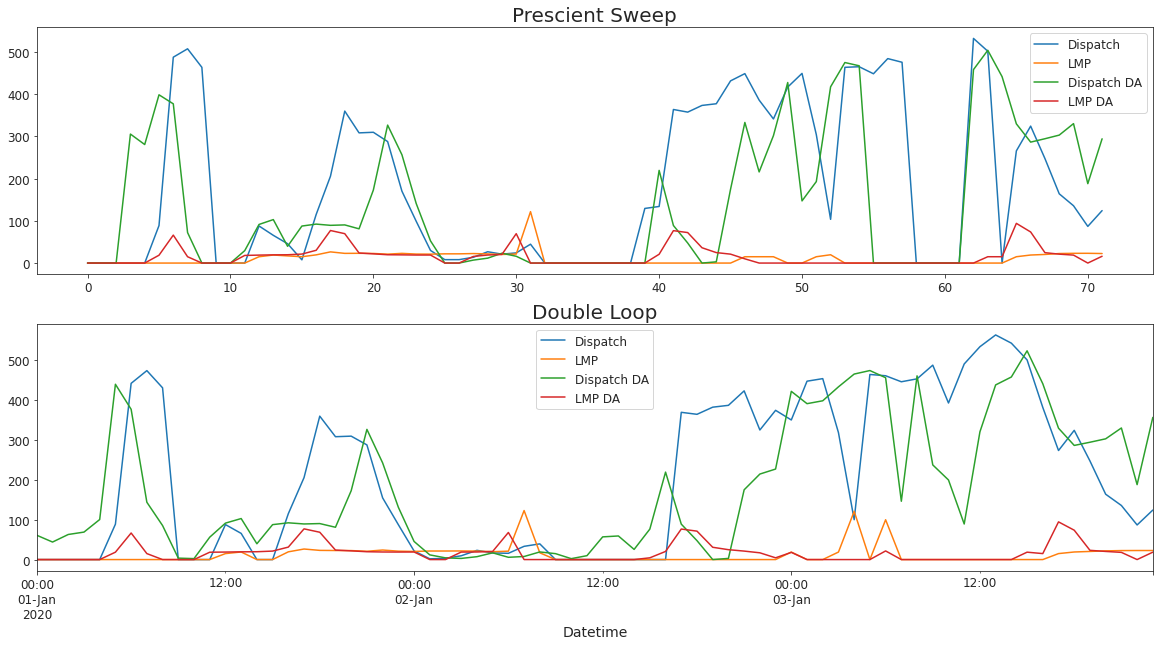

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sw_df.plot(ax=ax[0])
res[cols].plot(ax=ax[1])
ax[0].set_title("Prescient Sweep")
ax[1].set_title("Double Loop")